## 👜 Bag of Visual Words + SIFT

In this notebook, we shall extract the main features we are going to use in our model. Our strategy is to extract SIFT features for the image, then cluster those SIFT features using KMeans. Afterwards, compute the BoVW by mapping each new image to one of the clusters, and generating a histogram accordingly; that histogram will be our feature vector.

You can think of it as follows: the KMeans detects the clusters of patterns within the dataset, and the final feature vector just displays the frequency of each of those cluster patterns (for example, each cluster might represent a certain letter shape).

Check out the figure below for better understanding

![Moody BoVW.jpg](<attachment:Moody BoVW.jpg>)
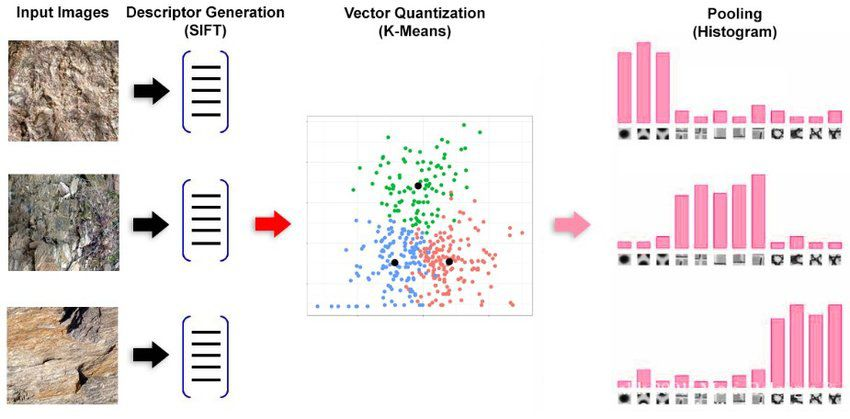

Let's start by importing the necessary dependencies

In [1]:
import numpy as np
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import joblib

from BoVW import BoVW
from utils import read_processed_data

We will now import the preprocessed dataset, and partition it into training and validation sets (note that the testing set is in a completely separate folder; it is totally ignored until the final testing phase)

In [21]:
data, labels = read_processed_data('../Preprocessed Dataset')
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.25, random_state=42)

Now, let's extract the BoVW features, and train the associated KMeans model that will be used for future extraction of new images.
Note that the KMeans is trained only once on the training data; it is blind to the data in the validation and testing sets to avoid any leakage of information

In [3]:
BoVW_extractor = BoVW()
X_train, kmeans = BoVW_extractor.extract_BoVW(X_train, k=200)
y_train = np.array(y_train)
X_train.shape

(2398, 200)

Each feature vector is of size 200 since the trained KMeans uses 200 clusters. As such, the histogram will have 200 entries

Let's now store the KMeans model, since it will be needed by all upcoming modules

In [18]:
joblib.dump(kmeans, "kmeans2.pkl")

Using our trained KMeans model, let's extract the same features from the validation set

In [22]:
BoVW_extractor = BoVW()
X_val, _ = BoVW_extractor.extract_BoVW(data=X_val, kmeans=kmeans)
y_val = np.array(y_val)
X_val.shape

(800, 200)

We have extracted all of the needed features from the training and validation set.
To make model training and hyperparameter tuning quicker and easier, we shall save the extracted features; all of the upcoming modules will use the features directly, and will be blind to the actual image

In [8]:
# Ensure y_train is a 2D column vector
y_train = y_train.reshape(-1, 1)

# Combine the arrays
combined_array = np.hstack((X_train, y_train))

# Save the combined array to a file
np.savetxt("Saved Features/BoVW_features_training_2.csv", combined_array, delimiter=",", fmt='%.16f')

In [23]:
# Ensure y_val is a 2D column vector
y_val = y_val.reshape(-1, 1)

# Combine the arrays
combined_array = np.hstack((X_val, y_val))

# Save the combined array to a file
np.savetxt("Saved Features/BoVW_features_validation_2.csv", combined_array, delimiter=",", fmt='%.16f')

## 👁️👃👁️ Let's Visualize

In [2]:
# Load the data from the file, assuming no missing values but using genfromtxt for its flexibility
data = np.genfromtxt("Saved Features/BoVW_features_training_2.csv", delimiter=",")

# Splitting into features and target variable
X_train_loaded = data[:, :-1]
y_train_loaded = data[:, -1]

In [3]:
# Load the data from the file, assuming no missing values but using genfromtxt for its flexibility
data = np.genfromtxt("Saved Features/BoVW_features_validation_2.csv", delimiter=",")

# Splitting into features and target variable
X_val_loaded = data[:, :-1]
y_val_loaded = data[:, -1]

We will visualize the features as follows:
- We will train PCA on the features
- Extract the best 2 principal components, and project all data points onto them
- VISUALIZE!

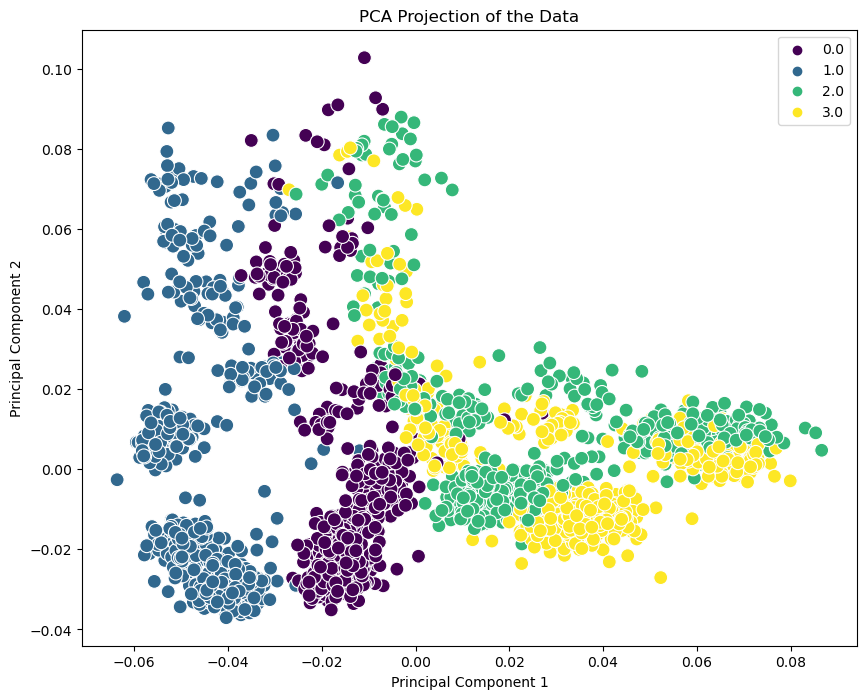

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

# Assuming X_train_loaded and y_train_loaded are already defined

# Fit PCA on the dataset
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_loaded)

# Create a scatter plot of the projected data
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train_loaded, palette='viridis', legend='full', s=100)

# Add title and labels
plt.title('PCA Projection of the Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Show the plot
plt.show()


You see, we have projected a 200 dimensional vector into a 2 dimensional one. Even after such a huge dimensionality reduction, there is still a clear separation between the classes! However, something is sus

<img src="https://media1.tenor.com/m/lL6lmpGAtSwAAAAd/cat-kid-retekmacska.gif" width=200/>

The classes 2 and 3 (Marhey and Scheherazade New) are quite mixed. We expect that in the 200 dimensional space, there will be great separation between them; but they might be the hardest to classify

Even still, the current results are quite satisfactory!
Let's go to the Feature Extraction notebook